In [110]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import tensorflow_decision_forests as tfdf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori
from efficient_apriori import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.neighbors import LocalOutlierFactor

In [2]:
dataset_train = pd.read_csv('train.csv')
dataset_test = pd.read_csv('test.csv')


In [3]:
dataset_train.head(3)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
dataset_test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [5]:
# print("Tamanho dos dados do train antes de remover o ID : {} ".format(dataset_train.shape))
# print("Tamanho dos dados do test antes de remover o ID : {} ".format(dataset_test.shape))

# #Salvando a coluna 'Id'
# dataset_train_ID = dataset_train['Id']
# dataset_test_ID = dataset_test['Id']

#Eliminando a coluna ID, pois ela não será necessária para a previsão
dataset_train.drop("Id", axis = 1, inplace = True)
dataset_test.drop("Id", axis = 1, inplace = True)


In [6]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

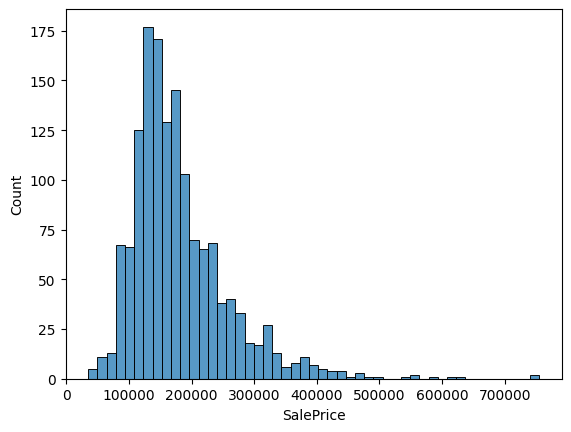

In [7]:
sns.histplot(dataset_train['SalePrice']);
#Histograma do SalePrice

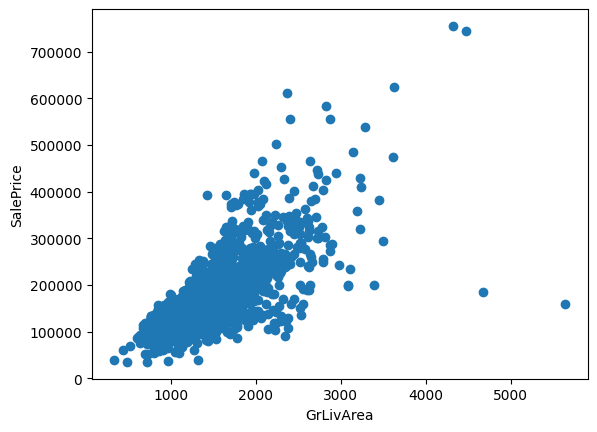

In [8]:
fig, ax = plt.subplots()
ax.scatter(x = dataset_train['GrLivArea'], y = dataset_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=10)
plt.xlabel('GrLivArea', fontsize=10)
plt.show()

#GrLivArea = Pés quadrados no nível do solo
#Vemos no canto inferior direito dois com GrLivArea extremamente grandes e com preço baixo. 


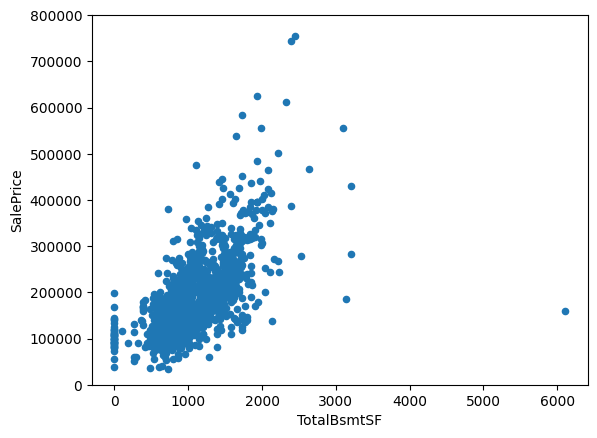

In [9]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([dataset_train['SalePrice'], dataset_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

#TotalBsmtSF = Total de Pés quadrados na área do porão

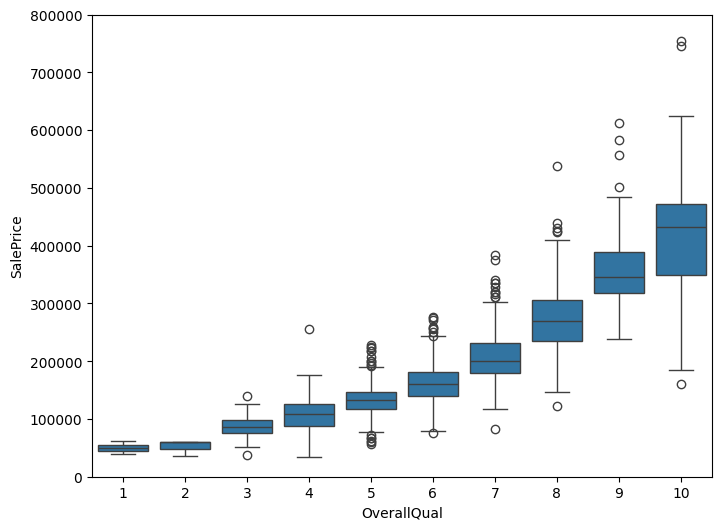

In [11]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([dataset_train['SalePrice'], dataset_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
#OverallQual = Material e qualidade do revestimento

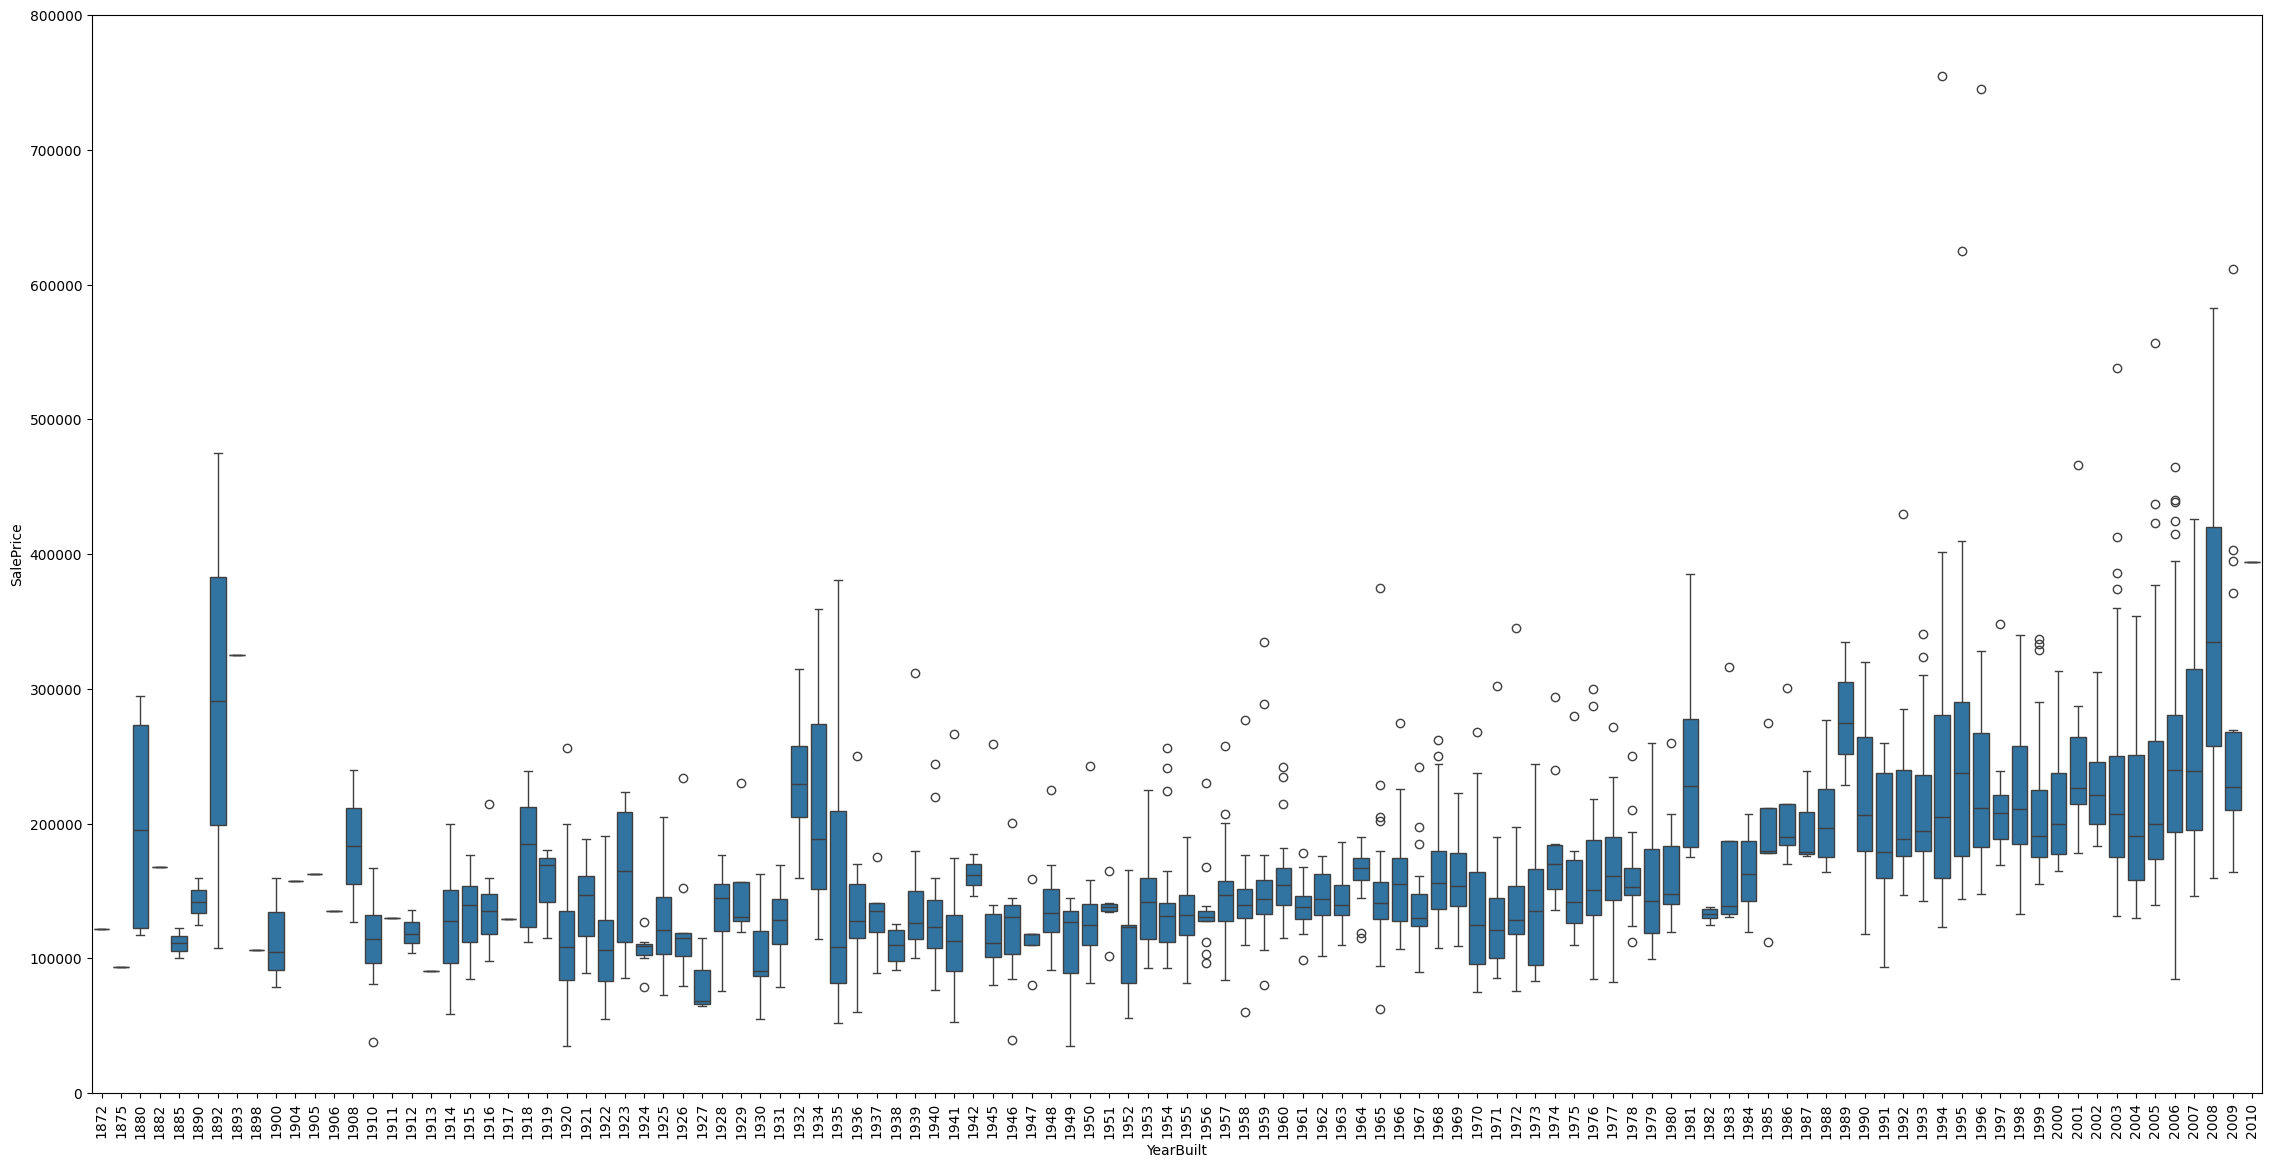

In [12]:
var = 'YearBuilt'
data = pd.concat([dataset_train['SalePrice'], dataset_train[var]], axis=1)
f, ax = plt.subplots(figsize=(28, 14))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

### Em resumo:

* 'GrLivArea' e 'TotalBsmtSF' mostram uma relação linear com 'SalePrice'. Ambas as relações são positivas, o que indica que a medida que uma variável aumenta, a outra também aumenta. Especialmente em relação a 'TotalBsmtSF', observamos uma inclinação particularmente alta na relação linear.
* 'OverallQual' e 'YearBuilt' também parecem influenciar 'SalePrice'. A influência parece ser mais forte em 'OverallQual', onde o gráfico de caixas mostra um aumento nos preços de venda conforme a qualidade geral melhora.


Com isso dito, vamos separar o que é relevante do que não é.





In [30]:
# Selecionando as variáveis para a regressão
df_regressao = dataset_train[['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'OverallQual']]

# Verificando as primeiras linhas do DataFrame
df_regressao.head()

,SalePrice,GrLivArea,TotalBsmtSF,OverallQual
0,208500,1710,856,7
1,181500,1262,1262,6
2,223500,1786,920,7
3,140000,1717,756,7
4,250000,2198,1145,8


In [32]:
df_regressao.describe()

,SalePrice,GrLivArea,TotalBsmtSF,OverallQual
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,1515.463699,1057.429452,6.099315
std,79442.502883,525.480383,438.705324,1.382997
min,34900.000000,334.000000,0.000000,1.000000
25%,129975.000000,1129.500000,795.750000,5.000000
50%,163000.000000,1464.000000,991.500000,6.000000
75%,214000.000000,1776.750000,1298.250000,7.000000
max,755000.000000,5642.000000,6110.000000,10.000000


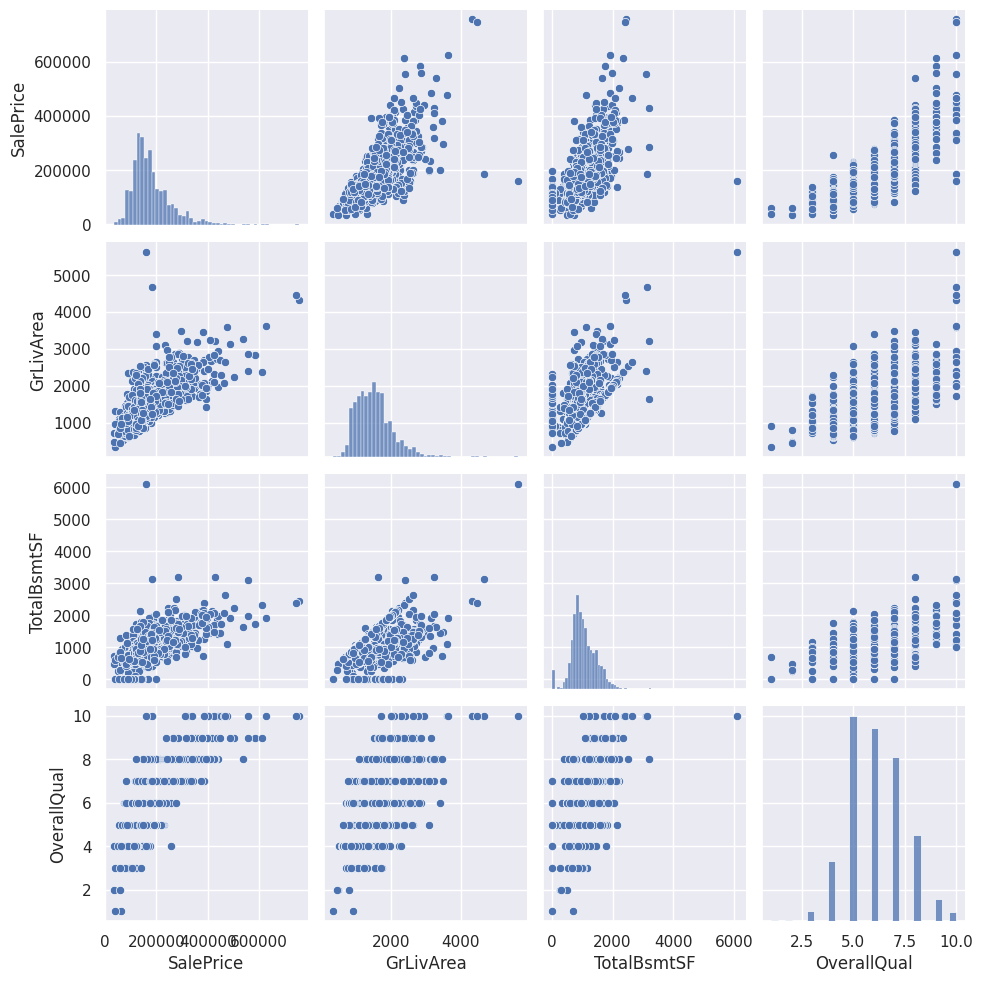

In [38]:
# Pairplot para visualizar as relações entre as variáveis
sns.pairplot(df_regressao)
plt.show()


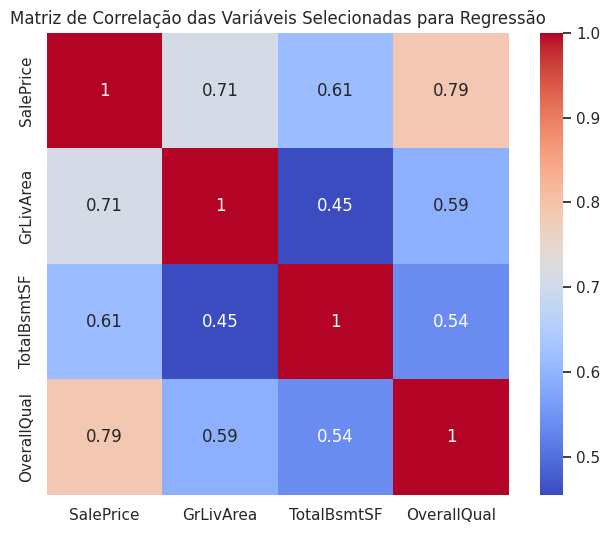

In [39]:
# Matriz de correlação
corr_matrix = df_regressao.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Matriz de Correlação das Variáveis Selecionadas para Regressão')
plt.show()

In [53]:
df_regressao = dataset_train[['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'OverallQual']].copy()
# Remover linhas com valores nulos, se houver
df_regressao.dropna(inplace=True)

# Separar variáveis independentes (X) e variável dependente (y)
X = df_regressao[['GrLivArea', 'TotalBsmtSF', 'OverallQual']]
y = df_regressao['SalePrice']

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizar as variáveis de entrada (opcional, mas pode melhorar o desempenho do modelo)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
# Construir o modelo sequencial
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Camada de entrada com o número de features
    tf.keras.layers.Dense(1)  # Camada densa com 1 neurônio para regressão linear
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [59]:
# Treinar o modelo
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39755767808.0000 - mse: 39755767808.0000 - val_loss: 39652818944.0000 - val_mse: 39652818944.0000
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37449961472.0000 - mse: 37449961472.0000 - val_loss: 39652798464.0000 - val_mse: 39652798464.0000
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39742947328.0000 - mse: 39742947328.0000 - val_loss: 39652773888.0000 - val_mse: 39652773888.0000
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38719913984.0000 - mse: 38719913984.0000 - val_loss: 39652753408.0000 - val_mse: 39652753408.0000
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39244877824.0000 - mse: 39244877824.0000 - val_loss: 39652732928.0000 - val_mse: 39652732928.0000
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39535788032.0000 - mse: 39535788032.0000 - val_loss: 39652708352.0000 - val_mse: 39652708352.0000
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 383384

In [61]:
# Fazer previsões
y_pred = model.predict(X_test_scaled).flatten()

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE (Mean Squared Error): {mse}')
print(f'R2 Score: {r2}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
MSE (Mean Squared Error): 39651738629.58183
R2 Score: -4.169498344467801


In [66]:
# Calcular a mediana dos preços de venda
median_price = dataset_train['SalePrice'].median()

# Criar variável binária para classificação
dataset_train['PriceCategory'] = pd.cut(dataset_train['SalePrice'], bins=[0, median_price, float('inf')], labels=['Low', 'High'])

# Verificar contagem de cada categoria
dataset_train['PriceCategory'].value_counts()

Low     732
High    728
Name: PriceCategory, dtype: int64

In [69]:
# Selecionar features para a classificação
features = ['GrLivArea', 'TotalBsmtSF', 'OverallQual']

# Separar variáveis independentes (X) e variável dependente (y)
X = dataset_train[features]
y = dataset_train['PriceCategory']

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizar as variáveis de entrada (opcional, mas pode melhorar o desempenho do modelo)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
# Criar e treinar o modelo de classificação
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Prever os valores para o conjunto de teste
y_pred = model.predict(X_test_scaled)

# Avaliar o desempenho do modelo
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Matriz de Confusão:
[[113  18]
 [ 17 144]]

Relatório de Classificação:
              precision    recall  f1-score   support

        High       0.87      0.86      0.87       131
         Low       0.89      0.89      0.89       161

    accuracy                           0.88       292
   macro avg       0.88      0.88      0.88       292
weighted avg       0.88      0.88      0.88       292



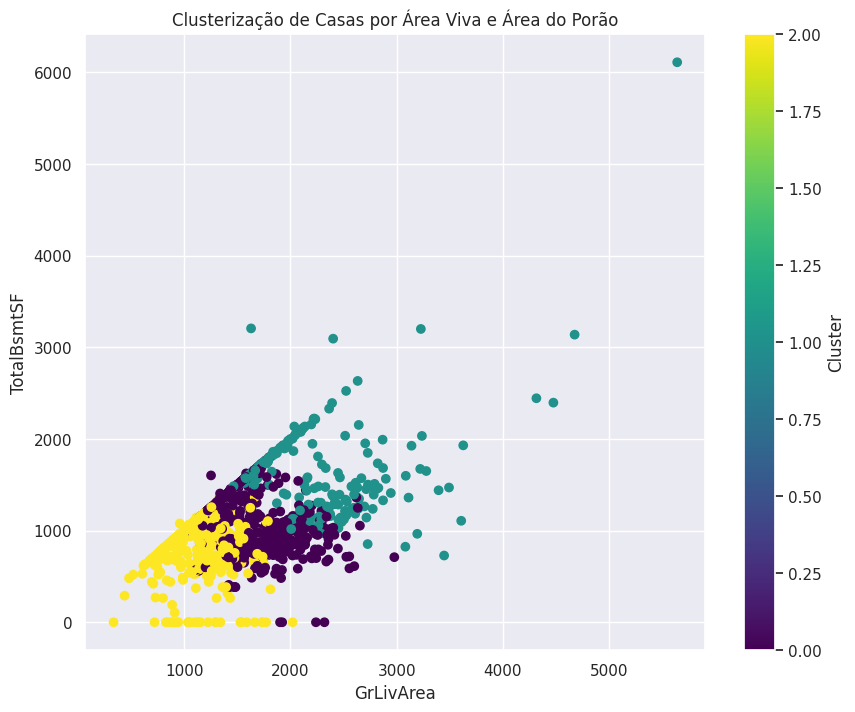

In [81]:
# Selecionar as features para clusterização
cluster_features = ['GrLivArea', 'TotalBsmtSF', 'OverallQual']

# Criar subset do dataset para clusterização
X_cluster = dataset_train[cluster_features]

# Normalizar os dados (opcional, mas geralmente recomendado para algoritmos baseados em distância)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Aplicar o algoritmo de clusterização (exemplo com KMeans)
kmeans = KMeans(n_clusters=3, random_state=42)
dataset_train['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Visualizar os clusters em relação a duas features (GrLivArea e TotalBsmtSF)
plt.figure(figsize=(10, 8))
plt.scatter(dataset_train['GrLivArea'], dataset_train['TotalBsmtSF'], c=dataset_train['Cluster'], cmap='viridis')
plt.title('Clusterização de Casas por Área Viva e Área do Porão')
plt.xlabel('GrLivArea')
plt.ylabel('TotalBsmtSF')
plt.colorbar(label='Cluster')
plt.show()

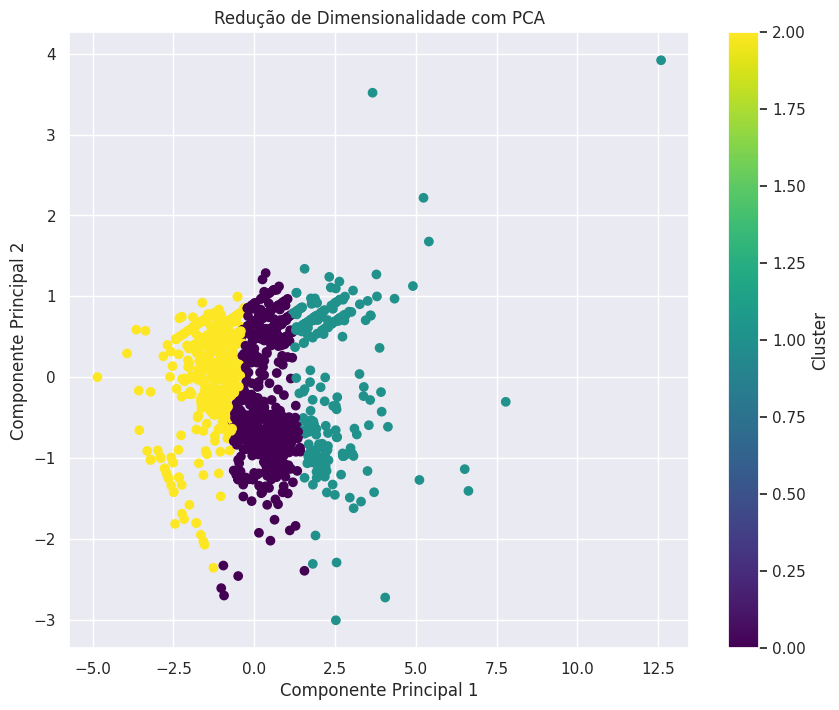

In [86]:
# Selecionar as features para PCA
pca_features = ['GrLivArea', 'TotalBsmtSF', 'OverallQual']

# Criar subset do dataset para PCA
X_pca = dataset_train[pca_features]

# Normalizar os dados
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Aplicar PCA
pca = PCA(n_components=2, random_state=42)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Criar DataFrame com os componentes principais
df_pca = pd.DataFrame(data=X_pca_transformed, columns=['Componente 1', 'Componente 2'])
df_pca['Cluster'] = dataset_train['Cluster']  # Adicionar os clusters como uma coluna

# Visualizar os clusters após a redução de dimensionalidade
plt.figure(figsize=(10, 8))
plt.scatter(df_pca['Componente 1'], df_pca['Componente 2'], c=df_pca['Cluster'], cmap='viridis')
plt.title('Redução de Dimensionalidade com PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

In [116]:
# Preparar os dados para Apriori
df_association = dataset_train[['OverallQual', 'GarageCars', 'FullBath', 'KitchenQual']]

# Convertendo para o formato de transações
transactions = []
for _, row in df_association.iterrows():
    transaction = [col for col, val in row.items() if val == 1]
    transactions.append(transaction)

# Aplicando o algoritmo Apriori
itemsets, rules = apriori(transactions, min_support=0.1, min_confidence=1)

# Exibindo regras de associação
for rule in rules:
    print(f"Regra: {rule}, Suporte: {rule.support}, Confiança: {rule.confidence}")

# Ordenando as regras por lift
sorted_rules = sorted(rules, key=lambda rule: rule.lift, reverse=True)
for rule in sorted_rules[:5]:  # Exibir as 5 primeiras regras com maior lift
    print(f"Regra: {rule}, Suporte: {rule.support}, Confiança: {rule.confidence}, Lift: {rule.lift}")

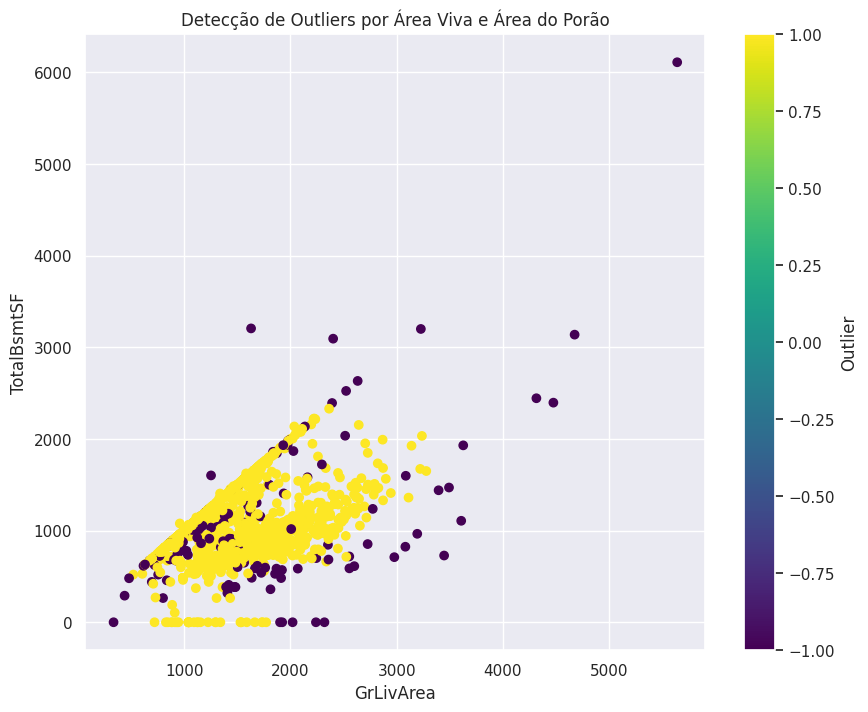

In [117]:


# Selecionar as features para detecção de outliers
outlier_features = ['GrLivArea', 'TotalBsmtSF', 'OverallQual']

# Criar subset do dataset para detecção de outliers
X_outliers = dataset_train[outlier_features]

# Normalizar os dados
scaler = StandardScaler()
X_outliers_scaled = scaler.fit_transform(X_outliers)

# Aplicar o algoritmo Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
dataset_train['Outlier'] = lof.fit_predict(X_outliers_scaled)

# Visualizar os outliers em relação a duas features (GrLivArea e TotalBsmtSF)
plt.figure(figsize=(10, 8))
plt.scatter(dataset_train['GrLivArea'], dataset_train['TotalBsmtSF'], c=dataset_train['Outlier'], cmap='viridis')
plt.title('Detecção de Outliers por Área Viva e Área do Porão')
plt.xlabel('GrLivArea')
plt.ylabel('TotalBsmtSF')
plt.colorbar(label='Outlier')
plt.show()


In [118]:
# Predição no conjunto de teste
y_pred_reg = model_regressao.predict(X_test_reg)

# Métricas de avaliação
mae_reg = mean_absolute_error(y_test_reg, y_pred_reg)
mse_reg = mean_squared_error(y_test_reg, y_pred_reg)
rmse_reg = mean_squared_error(y_test_reg, y_pred_reg, squared=False)
r2_reg = r2_score(y_test_reg, y_pred_reg)

print(f"Regressão Linear - Métricas de Avaliação:")
print(f"MAE: {mae_reg}")
print(f"MSE: {mse_reg}")
print(f"RMSE: {rmse_reg}")
print(f"R²: {r2_reg}")

NameError: name 'model_regressao' is not defined